# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
import sys

import tensorflow as tf
import tf_keras

# Add the parent directory to the path so that the custom utilities module is found
sys.path.insert(0, "..")

import utilities

g:\Backup\Documents\OpenCampus\Machine Learning With TensorFlow\Project\plain-language-classification-main\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Selection

The first step was to try an LSTM model to see if the preserving of sequence improves model performance. The LSTM model performed similar to the baseline model. Next, I tried using pre-trained embeddings to see if leveraging models trained on larger datasets aids performance. However, model performance did not increase, but even declined when using pre-trained embeddings from a Neural-Net Language Model. Lastly, a more advanced Transformer-based model was fine tuned to the project task, which finally yielded a substantial improvement over baseline performance.

## Feature Engineering

No additional feature engineering was done compared to the data preparation already implemented for the baseline model. However, for the Transformer-based model, stop words were left in, and larger sequence lengths were used.

In [2]:
has_duplicate_removal = True
has_stop_word_removal = True
validation_size = 0.1
test_size = 0.2

x_training, x_validation, x_test, y_training, y_validation, y_test = (
    utilities.prepare_and_split_data(
        has_duplicate_removal=has_duplicate_removal,
        has_stop_word_removal=has_stop_word_removal,
        validation_size=validation_size,
        test_size=test_size,
    )
)

print(f"Training set size: {len(x_training)}")
print(f"Validation set size: {len(x_validation)}")
print(f"Test set size: {len(x_test)}")

Training set size: 41943
Validation set size: 5992
Test set size: 11984


## Hyperparameter Tuning

Hyperparameters were tuned manually by trying different parameters such as layer size and learning rates and seeing what works best. In general, model performance was similar for varying parameter values. Naturally, automated hyperparameter tuning would be preferable over manual tuning, as this could systematically cover a wider range of possible values and objectively find an optimal solution. Such an automated approach using Grid Search or Random Search may be implemented in future versions.

## Implementation

As stated above, three different models were implemented and compared to the baseline model.

### Long Short-Term Memory Model

The first model is a bidirectional LSTM-model, which preservence information about the sequence of the words/tokens. As with the baseline model, embeddings are trained from scratch.

In [3]:
vocabulary_size = 10_000
maximum_sequence_length = 12
standardization_method = "lower"
dimensions_embedding = 32
units_lstm_1 = 64
units_lstm_2 = 32
units_lstm_3 = 8
units_dense = 8

model_lstm = utilities.build_model_lstm(
    x_training=x_training,
    vocabulary_size=vocabulary_size,
    maximum_sequence_length=maximum_sequence_length,
    standardization_method=standardization_method,
    dimensions_embedding=dimensions_embedding,
    units_lstm_1=units_lstm_1,
    units_lstm_2=units_lstm_2,
    units_lstm_3=units_lstm_3,
    units_dense=units_dense,
)

model_lstm.summary()

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 12)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 12, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 12, 128)        │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 12, 64)         │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_3            │ (None, 16)             │         4,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_relu (Dense)             │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_sigmoid (Dense)          │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,697 (1.59 MB)

 Trainable params: 415,697 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
number_of_epochs = 5
batch_size = 512

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

model_lstm.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_lstm = model_lstm.fit(
    x_training,
    y_training,
    epochs=number_of_epochs,
    batch_size=batch_size,
    validation_data=(x_validation, y_validation),
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - binary_accuracy: 0.7221 - loss: 0.5856 - val_binary_accuracy: 0.8486 - val_loss: 0.3479
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - binary_accuracy: 0.8732 - loss: 0.3024 - val_binary_accuracy: 0.8793 - val_loss: 0.2839
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9091 - loss: 0.2246 - val_binary_accuracy: 0.8778 - val_loss: 0.2834
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.9251 - loss: 0.1910 - val_binary_accuracy: 0.8735 - val_loss: 0.2992
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9308 - loss: 0.1773 - val_binary_accuracy: 0.8727 - val_loss: 0.3132


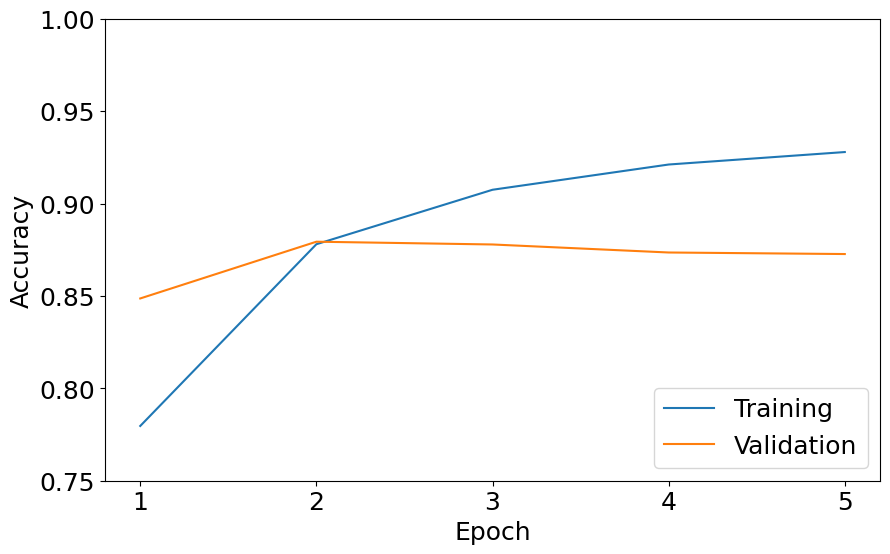

In [5]:
y_limits = (0.75, 1)

figure, axes = utilities.plot_accuracy(history=history_lstm, y_limits=y_limits)

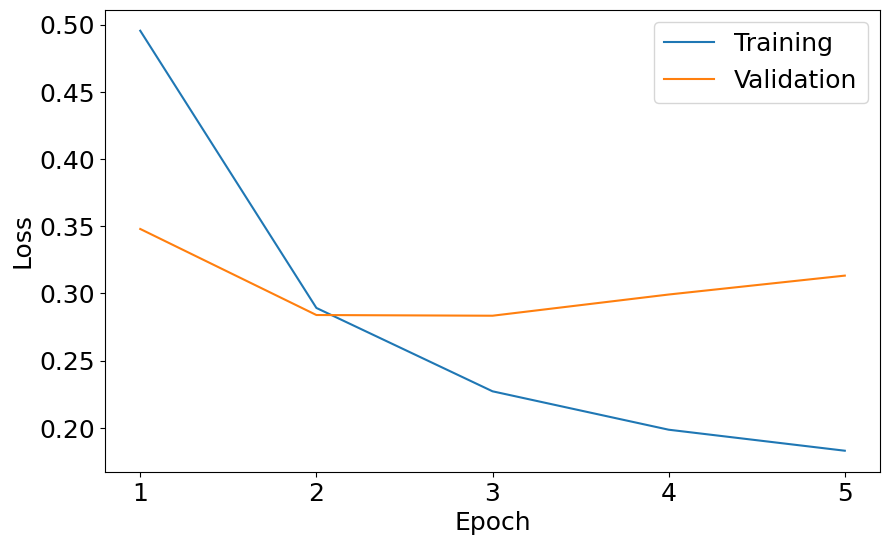

In [6]:
figure, axes = utilities.plot_loss(history=history_lstm)

### Model With Pre-Trained Embeddings From a Neural-Net Language Model

The second model is a structurally similar to the baseline model, but instead of training embeddings from scratch, pre-trained embeddings from an NNLM are used.

In [7]:
embedding_dimensions = 128  # can be 50 or 128
units_dense = 16
is_trainable = True

model_nnlm = utilities.build_model_nnlm(
    embedding_dimensions=embedding_dimensions,
    units_dense=units_dense,
)

model_nnlm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               125307520 
                                                                 
 hidden_relu (Dense)         (None, 16)                2064      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 17        
                                                                 
Total params: 125309601 (478.02 MB)
Trainable params: 125309601 (478.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
number_of_epochs = 50
batch_size = 512

initial_learning_rate = 5e-5

# tf_keras is used instead of tf.keras, because tensorflow_hub (Version 0.16.1) is incompatible with Keras 3
optimizer = tf_keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss = tf_keras.losses.BinaryCrossentropy()
metrics = [tf_keras.metrics.BinaryAccuracy()]

model_nnlm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

history_nnlm = model_nnlm.fit(
    x_training,
    y_training,
    epochs=number_of_epochs,
    batch_size=batch_size,
    validation_data=(x_validation, y_validation),
)

In [ ]:
y_limits = (0.5, 1)

figure, axes = utilities.plot_accuracy(history=history_nnlm, y_limits=y_limits)

In [ ]:
figure, axes = utilities.plot_loss(history=history_nnlm)

### Fine-Tuned German BERT

The third and final model is a fine-tuned version of the Transformer-based German BERT model.

In [9]:
has_duplicate_removal = True
has_stop_word_removal = False

x_training, x_validation, x_test, y_training, y_validation, y_test = (
    utilities.prepare_and_split_data(
        has_duplicate_removal=has_duplicate_removal,
        has_stop_word_removal=has_stop_word_removal,
        validation_size=validation_size,
        test_size=test_size,
    )
)

In [10]:
maximum_sequence_length = 30

data_training, data_validation, model_gbert = utilities.build_model_gbert(
    x_training=x_training.tolist(),
    x_validation=x_validation.tolist(),
    y_training=y_training.tolist(),
    y_validation=y_validation.tolist(),
    maximum_sequence_length=maximum_sequence_length,
)

model_gbert.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109927680 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109928449 (419.34 MB)
Trainable params: 109928449 (419.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 5
batch_size = 64
initial_learning_rate = 5e-5

# tf_keras is used instead of tf.keras, because transformers (Version 4.43.3) is incompatible with Keras 3
optimizer = tf_keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss = tf_keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf_keras.metrics.BinaryAccuracy()]

model_gbert.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history_gbert = model_gbert.fit(
    data_training.shuffle(1000).batch(batch_size),
    validation_data=data_validation.batch(batch_size),
    epochs=epochs,
    batch_size=batch_size,
)

In [ ]:
y_limits = (0.9, 1)

figure, axes = utilities.plot_accuracy(history=history_gbert, y_limits=y_limits)

In [ ]:
figure, axes = utilities.plot_loss(history=history_gbert)

## Evaluation Metrics

As with the baseline model, accuracy was chosen as the evaluation metric, since the two classes are well-balanced.

In [ ]:
accuracy_lstm = utilities.evaluate_model(
    model=model_lstm,
    x_test=x_test,
    y_test=y_test,
)


accuracy_nnlm = utilities.evaluate_model(
    model=model_nnlm,
    x_test=x_test,
    y_test=y_test,
)


accuracy_gbert = utilities.evaluate_model(
    model=model_gbert,
    x_test=x_test,
    y_test=y_test,
)

## Comparative Analysis

Performance was already quite high for the baseline model. This shows that a fairly simple model can already solve the task at hand pretty well, maybe because distinguishing between plain and regular language is not a particularly difficult task. The LSTM model performs similarly to the baseline model, suggesting that preserving word order does not improve model performance. Surprisingly, the model with pre-trained NNLM-embeddings performed even worse than the simple baseline model. The reasons for this bad performance are not quite clear. FInally, the fine-tuned version of German BERT outperformed all other models by a substantial margin. This high performance shows that the more advanced Transormer-based approach yields a superior text-classification accuracy, which is in line with existing research on the topic.

In [ ]:
accuracy_baseline = 0.876

print(f"Accuracy Baseline: {accuracy_baseline * 100:.1f}%")
print(f"Accuracy LSTM:  {accuracy_lstm * 100:.1f}%")
print(f"Accuracy NNLM: {accuracy_nnlm * 100:.1f}%")
print(f"Accuracy German BERT: {accuracy_gbert * 100:.1f}%")